In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install tensorflow pandas numpy matplotlib

**Load and splitting the data**

In [4]:
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Dataset path
images_path = os.path.join("/content/drive/MyDrive/105_classes_pins_dataset/")

# Function to count images in a folder
def count_images_in_folder(folder_path):
    return len([file for file in os.listdir(folder_path) if file.endswith(".jpg")])

# Get folders (names) with more than 170 images
sufficient_images_names = [
    folder for folder in os.listdir(images_path)
    if os.path.isdir(os.path.join(images_path, folder)) and count_images_in_folder(os.path.join(images_path, folder)) >= 170
]

print(f"Number of people with at least 170 images: {len(sufficient_images_names)}")

# Function to load image paths for a specific person
def load_image_paths_for_name(name, base_path):
    name_path = os.path.join(base_path, name)
    return [
        os.path.join(name_path, file)
        for file in os.listdir(name_path) if file.endswith(".jpg")
    ]

# Function to create DataFrame
def create_image_dataframe(names, base_path, test_size=0.2, random_state=42):
    data = []
    for name in names:
        # Load all image paths for the current name
        image_paths = load_image_paths_for_name(name, base_path)

        # Append to the data list
        data.extend([(path, name) for path in image_paths])

    # Convert the data into a DataFrame
    df = pd.DataFrame(data, columns=["image_path", "label"])

    # Split the DataFrame into train and test sets while ensuring all classes are represented
    train_df, test_df = train_test_split(df, test_size=test_size, stratify=df['label'], random_state=random_state)

    # Add a column to indicate the set
    train_df['set'] = 'train'
    test_df['set'] = 'test'

    # Combine train and test DataFrames
    combined_df = pd.concat([train_df, test_df], ignore_index=True)

    return combined_df

# Create the DataFrame
df = create_image_dataframe(sufficient_images_names, images_path)

# Verify train/test split
train_count = df[df["set"] == "train"].shape[0]
test_count = df[df["set"] == "test"].shape[0]
print(f"Number of training images: {train_count}")
print(f"Number of testing images: {test_count}")

# Example usage
train_df = df[df["set"] == "train"]
test_df = df[df["set"] == "test"]

print(f"Train DataFrame sample:\n{train_df.head()}")
print(f"Test DataFrame sample:\n{test_df.head()}")

# Get the label counts for train and test sets
train_label_counts = df[df["set"] == "train"]['label'].value_counts()
test_label_counts = df[df["set"] == "test"]['label'].value_counts()

label_counts = pd.DataFrame({
    'Train': train_label_counts,
    'Test': test_label_counts
}).fillna(0)  # Fill missing labels with 0

Number of people with at least 170 images: 51
Number of training images: 7982
Number of testing images: 1996
Train DataFrame sample:
                                          image_path                label  \
0  /content/drive/MyDrive/105_classes_pins_datase...  pins_Tom Hiddleston   
1  /content/drive/MyDrive/105_classes_pins_datase...     pins_Miley Cyrus   
2  /content/drive/MyDrive/105_classes_pins_datase...     pins_Chris Pratt   
3  /content/drive/MyDrive/105_classes_pins_datase...    pins_Selena Gomez   
4  /content/drive/MyDrive/105_classes_pins_datase...       pins_Zac Efron   

     set  
0  train  
1  train  
2  train  
3  train  
4  train  
Test DataFrame sample:
                                             image_path  \
7982  /content/drive/MyDrive/105_classes_pins_datase...   
7983  /content/drive/MyDrive/105_classes_pins_datase...   
7984  /content/drive/MyDrive/105_classes_pins_datase...   
7985  /content/drive/MyDrive/105_classes_pins_datase...   
7986  /content/drive

In [5]:
# Check for any test labels not present in the train data
unseen_test_labels = test_df[~test_df['label'].isin(train_df['label'])]

if not unseen_test_labels.empty:
    print(f"Unseen test labels: \n{unseen_test_labels}")
else:
    print("All test labels are present in the train set.")

All test labels are present in the train set.



**Label Encoding**

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
train_df.loc[:, 'encoded_label'] = label_encoder.fit_transform(train_df['label'])
test_df.loc[:, 'encoded_label'] = label_encoder.transform(test_df['label'])

print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("Class Distribution in Train Data:\n", train_df['encoded_label'].value_counts())

Train Data Shape: (7982, 4)
Test Data Shape: (1996, 4)
Class Distribution in Train Data:
 encoded_label
18    190
30    186
16    181
1     180
43    177
48    177
41    174
0     170
19    170
40    169
8     169
7     168
23    167
4     167
32    163
47    162
3     162
49    161
45    159
42    158
34    158
27    158
2     157
10    156
21    154
33    154
20    154
38    153
25    153
36    151
44    150
9     150
39    149
31    149
12    147
46    146
14    146
35    145
6     145
50    144
13    144
37    143
11    143
29    142
15    142
24    142
22    142
5     141
26    140
17    137
28    137
Name: count, dtype: int64


<ipython-input-6-99d249c28eec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'encoded_label'] = label_encoder.fit_transform(train_df['label'])
<ipython-input-6-99d249c28eec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:, 'encoded_label'] = label_encoder.transform(test_df['label'])


**Create a TensorFlow Dataset, Normalization and Data Augmentation**

In [7]:
import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input

# Preprocess image
def preprocess_image(img_path, label):
    # Load image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode image
    img = tf.image.resize(img, [224, 224])  # Resize to target size
    img = preprocess_input(img)  # Apply DenseNet preprocessing
    return img, label

# Create a TensorFlow dataset
def create_dataset(df, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((df['image_path'].values, df['encoded_label'].astype(int).values))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) # Apply preprocess_image to each image
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE) # randomize image order
    return dataset

def augment_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    return img, label


batch_size = 32
train_dataset = create_dataset(train_df, batch_size)
test_dataset = create_dataset(test_df, batch_size)

train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE) #apply augmentation only to the training dataset

print("Train Dataset:", train_dataset)
print("Test Dataset:", test_dataset)

Train Dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Test Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


**Load DenseNet Model**

In [8]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
import numpy as np

# Set image dimensions
img_height, img_width = 224, 224

# Load DenseNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x= base_model.layers[-3].output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)  # Dropout to reduce overfitting
x = Dense(256,activation='relu')(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model's layers to prevent them from being trained
for layer in model.layers[:-9]:
    layer.trainable = False

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,702,643 (29.38 MB)

 Trainable params: 706,355 (2.69 MB)

 Non-trainable params: 6,996,288 (26.69 MB)

In [9]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy


# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30,
    shuffle=True, # Shuffles the dataset before each epoch
    verbose=1
    )

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2417s 9s/step - accuracy: 0.0262 - loss: 3.9165 - val_accuracy: 0.0741 - val_loss: 3.7853
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 222ms/step - accuracy: 0.0672 - loss: 3.6920 - val_accuracy: 0.0701 - val_loss: 3.3804
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 219ms/step - accuracy: 0.0912 - loss: 3.3504 - val_accuracy: 0.1298 - val_loss: 3.2096
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 60s 217ms/step - accuracy: 0.1249 - loss: 3.2026 - val_accuracy: 0.1733 - val_loss: 3.0810
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 92s 258ms/step - accuracy: 0.1478 - loss: 3.0742 - val_accuracy: 0.1904 - val_loss: 2.9783
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 258ms/step - accuracy: 0.1734 - loss: 2.9769 - val_accuracy: 0.2064 - val_loss: 2.9021
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 256ms/step - accuracy: 0.2021 - loss: 2.9016 - val_accuracy: 0.2239 - val_loss: 2.8397
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 256ms/step - accuracy: 0.2050 - loss: 2.

In [10]:
from tensorflow.keras.models import Model
import numpy as np
# Evaluate on test data
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Collect true labels and predicted probabilities
y_true = []
y_pred_prob = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # Convert tensors to numpy arrays
    y_pred_prob_batch = model.predict(images)
    y_pred_prob.extend(y_pred_prob_batch)  # Collect predicted probabilities

# Convert y_true and y_pred_prob to numpy arrays for processing
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.4144 - loss: 2.0970
Test Loss: 2.0963051319122314
Test Accuracy: 0.40631261467933655
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/

**Visualization**

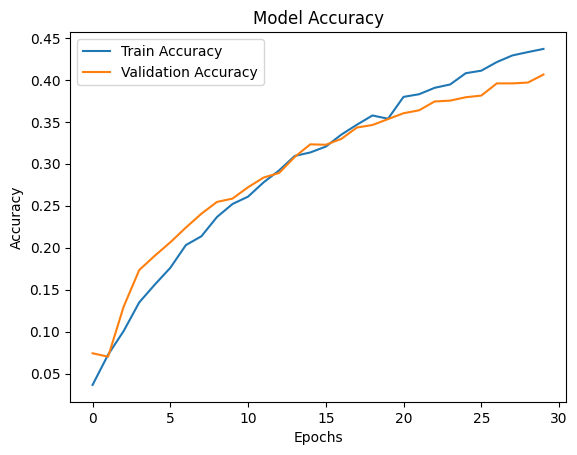

In [11]:
import matplotlib.pyplot as plt

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

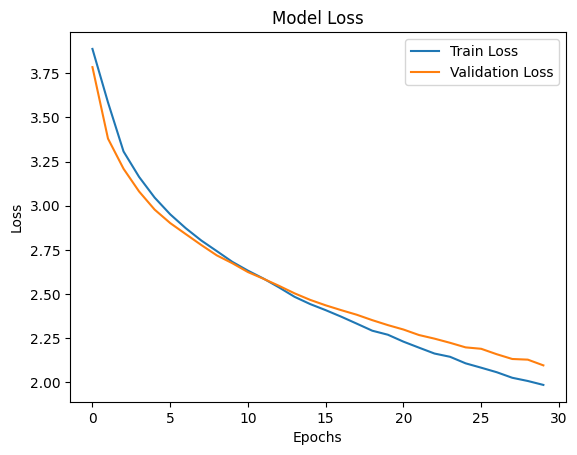

In [12]:
import matplotlib.pyplot as plt

# Plot training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

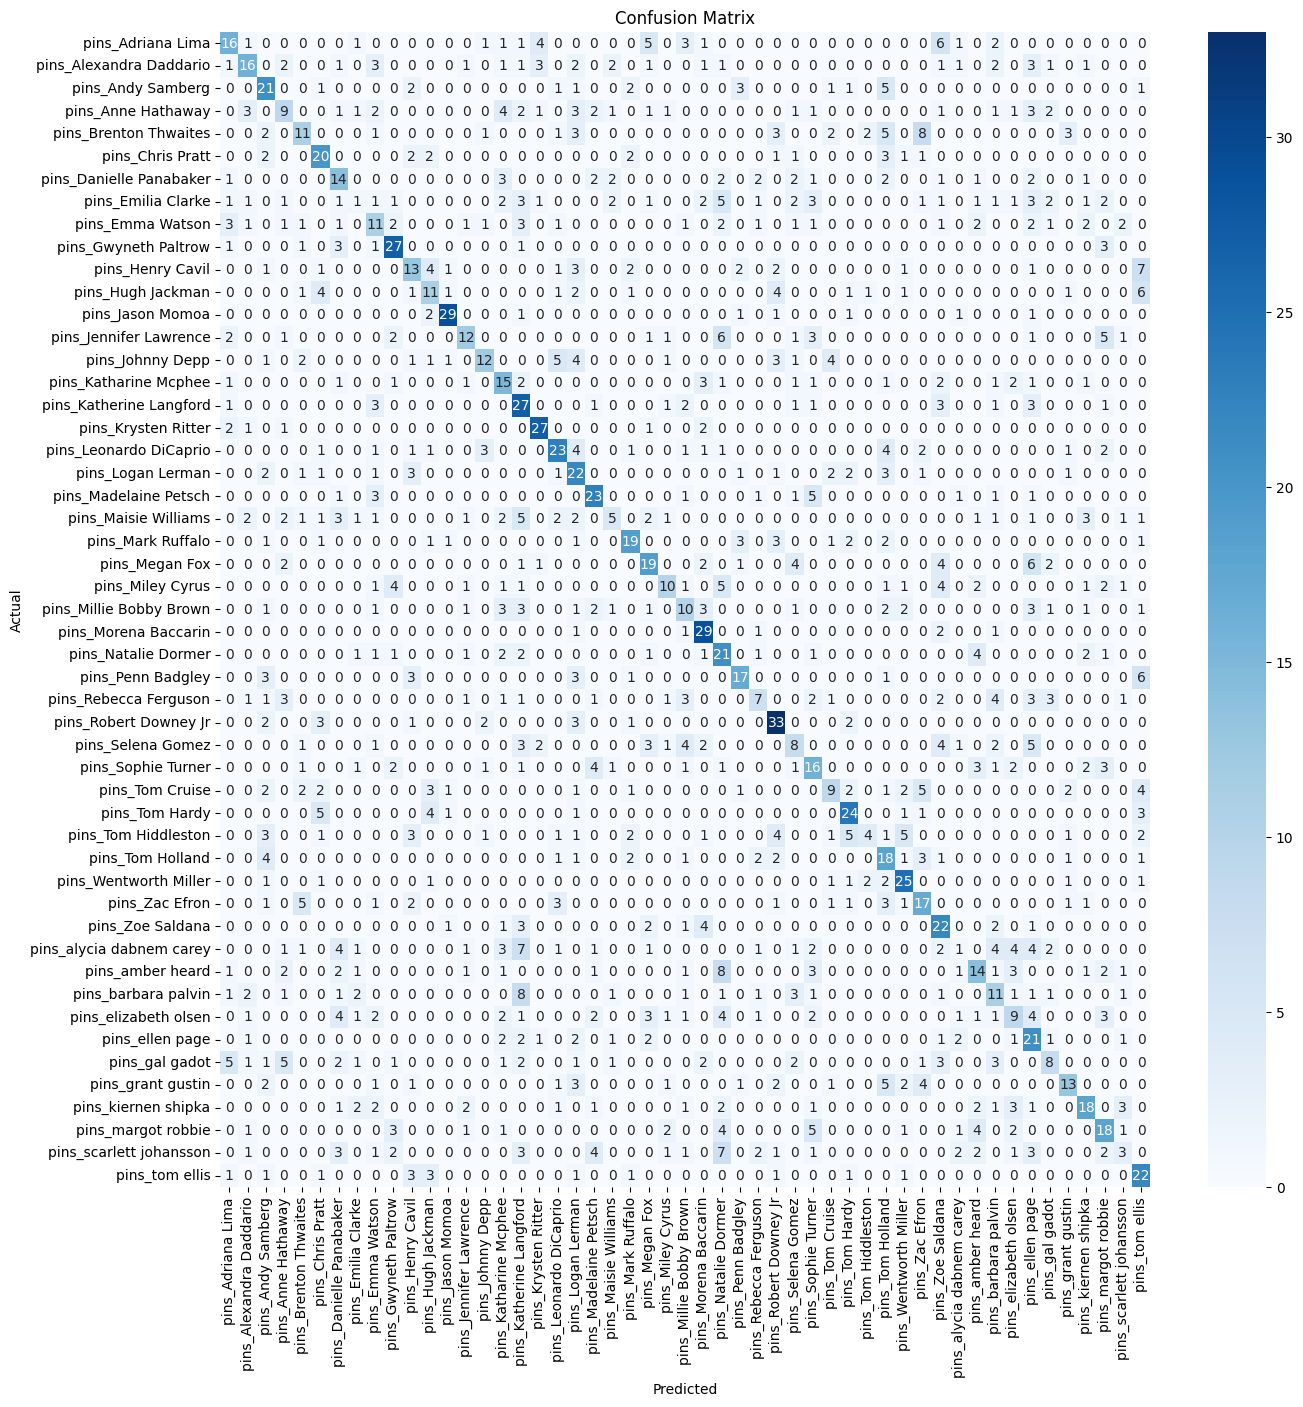

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix Visualization
y_pred_classes = np.argmax(y_pred_prob, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Precision, Recall, and F1 Score
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.4010
Recall: 0.4095
F1 Score: 0.3921


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

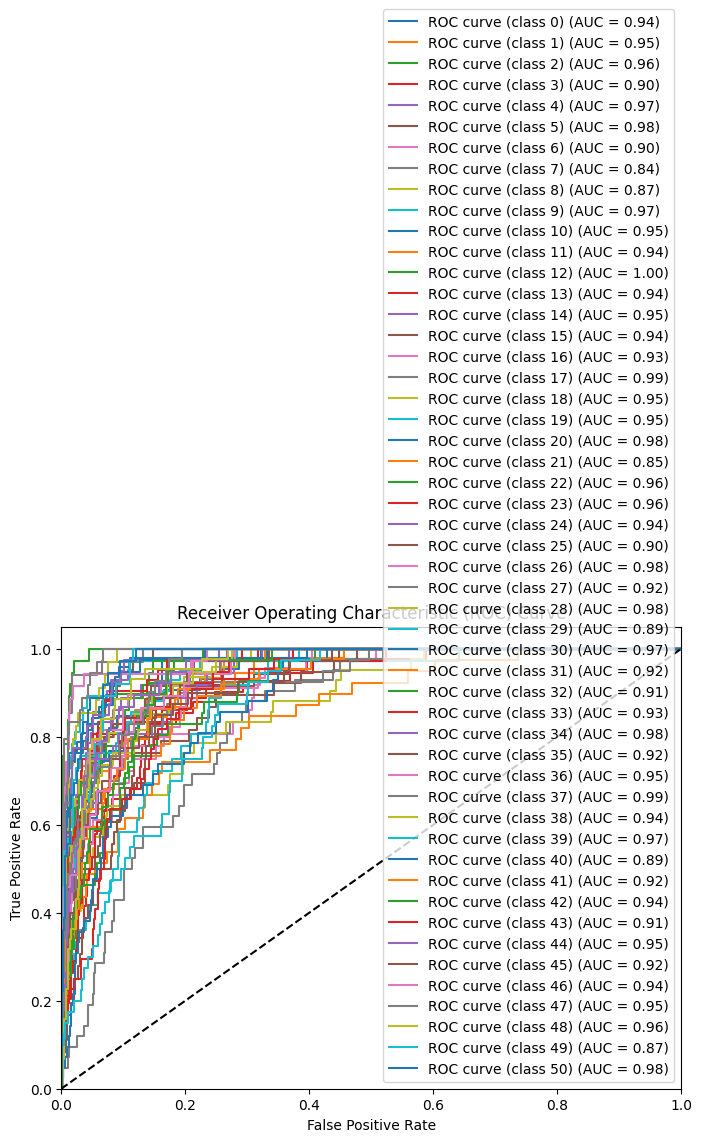

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(label_encoder.classes_)  # Get the number of classes from the label encoder

# Iterate over the dataset to collect true labels and predictions
y_true = []
y_pred_prob = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # Convert tensors to numpy arrays
    y_pred_prob_batch = model.predict(images)
    y_pred_prob.extend(y_pred_prob_batch)  # Collect predicted probabilities

# Convert y_true and y_pred_prob to numpy arrays for processing
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Compute the ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()